# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [55]:
from bs4 import BeautifulSoup
import requests
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd


In [2]:
# Seleccionar el recurso a descargar
resource_url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
# Para evitar que el servidor bloquee la peticion
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
# Petición para descargar el html de wikipedia
response = requests.get(resource_url, headers=headers)

# Si la petición se ha ejecutado correctamente (código 200), entonces el contenido HTML de la página se ha podido descargar
if response:
    # Transformamos el HTML plano en un LXML (estructurado y anidado, con forma de árbol)
    soup = BeautifulSoup(response.content, 'html')
    soup

In [3]:
#Selecionamos la primera tabla de la pagina que contiene las canciones
tables = soup.find_all('table')
table = tables[0].find('tbody')
table

<tbody><tr>
<th>Rank
</th>
<th>Song
</th>
<th>Artist(s)
</th>
<th>Streams<br/>(billions)
</th>
<th>Release date
</th>
<th class="unsortable"><abbr title="References">Ref.</abbr>
</th></tr>
<tr>
<td style="text-align:center;">1
</td>
<th scope="row">"<a href="/wiki/Blinding_Lights" title="Blinding Lights">Blinding Lights</a>"
</th>
<td style="text-align:left;"><a href="/wiki/The_Weeknd" title="The Weeknd">The Weeknd</a></td>
<td style="text-align:center;">5.278</td>
<td style="text-align:right;"><span data-sort-value="000000002019-11-29-0000" style="white-space:nowrap">29 November 2019</span></td>
<td style="text-align:center;"><sup class="reference" id="cite_ref-1"><a href="#cite_note-1"><span class="cite-bracket">[</span>1<span class="cite-bracket">]</span></a></sup>
</td></tr>
<tr>
<td style="text-align:center;">2
</td>
<th scope="row">"<a href="/wiki/Shape_of_You" title="Shape of You">Shape of You</a>"
</th>
<td style="text-align:left;"><a href="/wiki/Ed_Sheeran" title="Ed Sheeran">

In [4]:
def clean_text(x):
    datos = x.find_all(['td','th'])
    for i in range(len(datos)):
        aux=datos[i].text.strip()
        if "$" in aux:
            aux=datos[i].replace('$', '')
        
        datos[i]=aux
    return datos

rows = table.find_all('tr')
headers = rows[0:1]
tuples = rows[1:]
headers = list(map(clean_text, headers))
tuples = list(map(clean_text, tuples))

In [38]:
df = pd.DataFrame(tuples, columns=headers[0])
df = df.iloc[:, :-1]
df = df.replace('', pd.NA)
df = df.dropna(how='any')
def convertir_fecha(fecha_str):
    fecha = datetime.strptime(fecha_str, "%d %B %Y")
    return fecha.strftime("%Y-%m-%d")
df["Release date"] = df["Release date"].apply(convertir_fecha)
df["Streams(billions)"] = df["Streams(billions)"].apply(lambda x: round(float(x),2))
df

,Rank,Song,Artist(s),Streams(billions),Release date
0,1,"""Blinding Lights""",The Weeknd,5.28,2019-11-29
1,2,"""Shape of You""",Ed Sheeran,4.77,2017-01-06
2,3,"""Sweater Weather""",The Neighbourhood,4.38,2012-12-03
3,4,"""Starboy""",The Weeknd and Daft Punk,4.37,2016-09-21
4,5,"""As It Was""",Harry Styles,4.25,2022-04-01
...,...,...,...,...,...
95,96,"""Payphone""",Maroon 5 and Wiz Khalifa,2.55,2012-04-16
96,97,"""Dreams""",Fleetwood Mac,2.55,1977-02-04
97,98,"""Sicko Mode""",Travis Scott and Drake,2.53,2018-08-21
98,99,"""Billie Jean""",Michael Jackson,2.52,1982-11-29


In [13]:

conn = sqlite3.connect("spotify_rank.db")
query="""CREATE TABLE IF NOT EXISTS spotify_rank (
    id INTEGER PRIMARY KEY,
    rank INTEGER,
    song TEXT,
    artist TEXT,
    streams REAL,
    release_date DATE
);
"""
cur = conn.cursor()
cur.execute(query)
conn.commit()

delete_query="""
DELETE FROM spotify_rank WHERE 1
"""
cur = conn.cursor()
cur.execute(delete_query)
conn.commit()



In [15]:
cur = conn.cursor()
for tupla in df.itertuples():
    query=f"""
    INSERT INTO spotify_rank VALUES ({tupla[0]},{tupla[1]},{tupla[2]},"{tupla[3]}",{float(tupla[4])},"{tupla[5]}");
    """
    cur.execute(query)
   
conn.commit()
conn.close()


In [16]:
conn = sqlite3.connect("spotify_rank.db")
cur = conn.cursor()
query_test = """
SELECT * FROM spotify_rank
""" 
result = cur.execute(query_test).fetchall()
print(result)
conn.close()

[(0, 1, 'Blinding Lights', 'The Weeknd', 5.278, '2019-11-29'), (1, 2, 'Shape of You', 'Ed Sheeran', 4.769, '2017-01-06'), (2, 3, 'Sweater Weather', 'The Neighbourhood', 4.381, '2012-12-03'), (3, 4, 'Starboy', 'The Weeknd and Daft Punk', 4.365, '2016-09-21'), (4, 5, 'As It Was', 'Harry Styles', 4.248, '2022-04-01'), (5, 6, 'Someone You Loved', 'Lewis Capaldi', 4.224, '2018-11-08'), (6, 7, 'Sunflower', 'Post Malone and Swae Lee', 4.12, '2018-10-18'), (7, 8, 'One Dance', 'Drake with Wizkid and Kyla', 4.038, '2016-04-05'), (8, 9, 'Perfect', 'Ed Sheeran', 3.829, '2017-03-03'), (9, 10, 'Stay', 'The Kid LAROI and Justin Bieber', 3.798, '2021-07-09'), (10, 11, 'Believer', 'Imagine Dragons', 3.744, '2017-02-01'), (11, 12, 'Heat Waves', 'Glass Animals', 3.658, '2020-06-29'), (12, 13, 'Lovely', 'Billie Eilish and Khalid', 3.647, '2018-04-19'), (13, 14, 'I Wanna Be Yours', 'Arctic Monkeys', 3.599, '2013-09-09'), (14, 15, 'Closer', 'The Chainsmokers and Halsey', 3.598, '2016-07-29'), (15, 16, 'The 

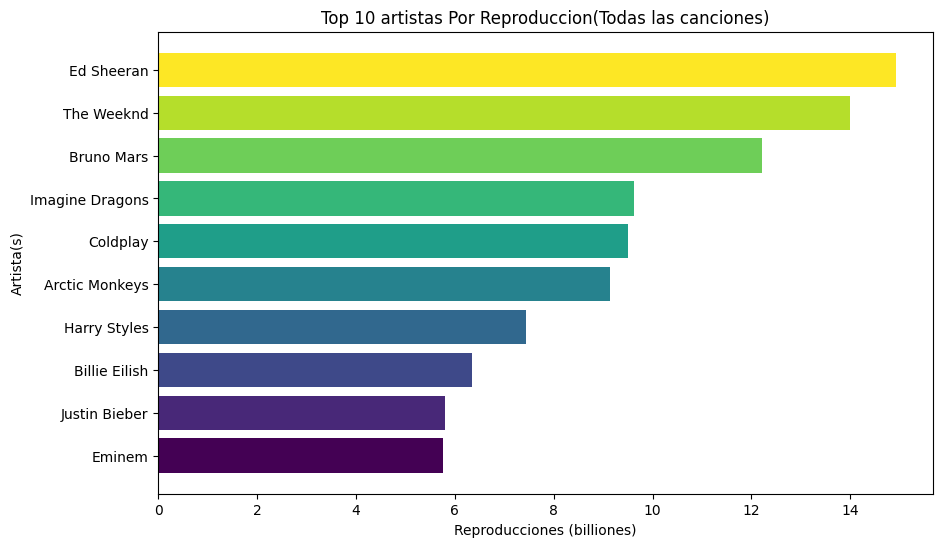

In [63]:
# viridis pero en una serie
colors = [
    "#440154",
    "#482878",
    "#3e4989",
    "#31688e",
    "#26828e",
    "#1f9e89",
    "#35b779",
    "#6ece58",
    "#b5de2b",
    "#fde725"
]

top10_streams = (
    df.groupby("Artist(s)")["Streams(billions)"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .sort_values(ascending=True)
      .reset_index()
)
plt.figure(figsize=(10,6))
plt.barh(top10_streams["Artist(s)"], top10_streams["Streams(billions)"],color=colors)
plt.xlabel("Reproducciones (billiones)")
plt.ylabel("Artista(s)")
plt.title("Top 10 artistas Por Reproduccion(Todas las canciones)")
plt.show()





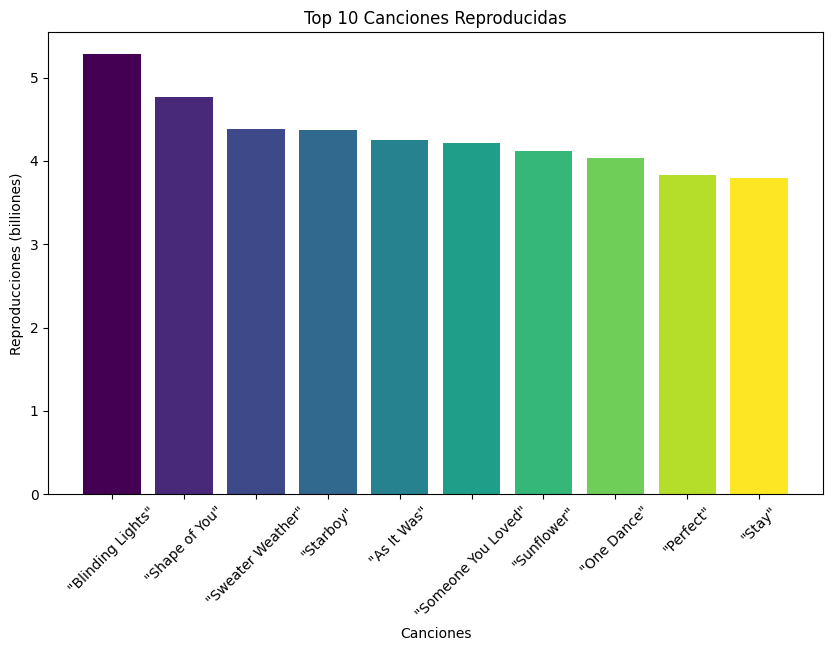

In [ ]:

top10_songs = (
    df.sort_values("Streams(billions)",ascending=False)
      .head(10)
      .reset_index()
)
plt.figure(figsize=(10,6))
plt.bar(top10_songs["Song"], top10_songs["Streams(billions)"],color=colors[::-1])
plt.ylabel("Reproducciones (billiones)")
plt.xlabel("Canciones")
plt.xticks(rotation=45)
plt.title("Top 10 Canciones Reproducidas")
plt.show()

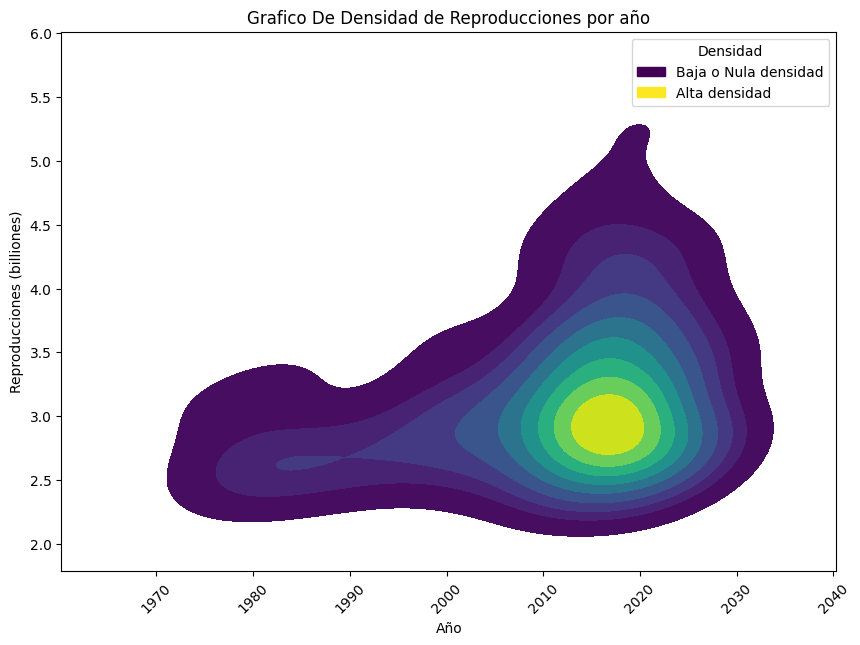

In [62]:
df["Release date"] = pd.to_datetime(df["Release date"])
plt.figure(figsize=(10,7))
sns.kdeplot(
    data=df,
    x="Release date",
    y="Streams(billions)",
    fill=True,
    cmap="viridis",
    thresh=0.05
)
cmin = colors[0]  
cmax = colors[-1] 

patch_min = mpatches.Patch(color=cmin, label="Baja o Nula densidad")
patch_max = mpatches.Patch(color=cmax, label="Alta densidad")

plt.legend(handles=[patch_min, patch_max], title="Densidad")

plt.ylabel("Reproducciones (billiones)")
plt.xlabel("Año")
plt.title("Grafico De Densidad de Reproducciones por año")
plt.xticks(rotation=45)
plt.show()
